## Задачи сегментации фасадов и детекции объектов (окна, колонны)

#### Необходимо обучить собственный алгоритм tensorflow сегментации фасада главного здания, а также алгоритм определения числа окон и числа колонн.
#### Заказчик хотел бы выделять на фото фасад "главного" здания, если на изображении несколько зданий.

Решение задачи требует создания нескольких алгоритмов машинного обучения для решения трех различных задач:

* Сегментация фасада главного здания на изображении
* Определение числа окон на фасаде
* Определение числа колонн на фасаде

Для решения каждой из этих задач можно использовать различные алгоритмы машинного обучения, такие как нейронные сети и алгоритмы компьютерного зрения.

Например, для **сегментации фасада главного здания на изображении можно использовать алгоритмы семантической сегментации**, такие как FCN, U-Net или SegNet, которые могут обучаться на размеченных данных, где каждый пиксель на изображении помечен как принадлежащий к фасаду или нет.

Для **определения числа окон и числа колонн на фасаде можно использовать алгоритмы детектирования объектов**, такие как Faster R-CNN, RetinaNet или YOLO, которые могут обучаться на размеченных данных, где каждый объект (окно или колонна) на изображении помечен с помощью ограничивающей рамки.

Также можно использовать готовые модели машинного обучения, предварительно обученные на больших наборах данных, такие как ImageNet, и дообучать их на своих размеченных данных.

Однако, чтобы создать алгоритмы машинного обучения для решения этих задач, необходимо иметь доступ к размеченным данным, то есть набору изображений, на которых фасады главного здания помечены, а также размечены окна и колонны. Такие данные были получены на первом этапе предобработки данных путем ручной разметки изображений.

Кроме того, необходимо провести оценку качества полученных моделей машинного обучения на тестовых данных, чтобы убедиться в их эффективности и точности. Для этого можно использовать метрики, такие как точность, полноту и F1-меру, а также визуально сравнить результаты работы модели с оригинальными изображениями.

Кроме того, стоит учитывать, что **задача определения числа окон и колонн на фасаде может быть достаточно сложной, особенно если на изображении находятся объекты разных размеров, расположенные на разном расстоянии от камеры, в разных условиях освещения и т.д. Поэтому для получения точных результатов может потребоваться использование дополнительных методов предобработки изображений, таких как поворот, масштабирование и улучшение контрастности.**

*Для обучения моделей используем U-Net и YOLO, так как работаем без GPU-ускорителя и ограничены домашним ноутбуком и мощностями Google Colab.*


In [1]:
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import webcolors
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Color Mapping

**Создадим словарь 'color_mapping', который содержит отображение цветов в числовые значения.**

Ключи словаря - это цвета в формате RGB (каждая цифра от 0 до 255), которые представлены в виде кортежа из трех чисел. Значения словаря - это числовые метки, которые соответствуют определенной категории (фон, фасад, окна, двери, карниз, подоконник, балкон, жалюзи, декоративные элементы, молдинги, столбы и магазины).

Таким образом, при обработке изображения с помощью этого словаря, программа будет проверять каждый пиксель на соответствие цвету из словаря и присваивать ему числовое значение, соответствующее соответствующей категории.

* 1 background 1
* 2 facade 2
* 3 window 10
* 4 door 5
* 5 cornice 11
* 6 sill 3
* 7 balcony 4
* 8 blind 6
* 9 deco 8
* 10 molding 7
* 11 pillar 12
* 12 shop 9

In [2]:
color_mapping = {
    (0, 0, 0): 1,    # background
    (255, 0, 0): 2,  # facade
    (0, 255, 0): 10, # window
    (0, 0, 255): 5,  # door
    (255, 255, 0): 11, # cornice
    (255, 128, 0): 3, # sill
    (128, 255, 0): 4, # balcony
    (255, 0, 255): 6, # blind
    (128, 0, 255): 8, # deco
    (0, 255, 255): 7, # molding
    (255, 0, 128): 12, # pillar
    (255, 255, 255): 9 # shop
}

Теперь напишем код, который загружает маску (изображение, на котором каждый цвет соответствует определенной категории объектов) и создает пустой массив для меток классов. Затем он проходит в цикле по каждому пикселю маски и присваивает соответствующую метку класса на основе значения цвета.

Если значение цвета не соответствует ни одному цвету из словаря color_mapping, то метке класса присваивается значение 0 (предполагается, что это фон). Результатом работы этого кода является массив labels, содержащий метки классов для каждого пикселя маски.

In [3]:
train_path = os.path.abspath("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train")
print(os.listdir(train_path))

['cmp_b0001.jpg', 'cmp_b0001.png', 'cmp_b0002.jpg', 'cmp_b0002.png', 'cmp_b0003.jpg', 'cmp_b0003.png', 'cmp_b0004.jpg', 'cmp_b0004.png', 'cmp_b0005.jpg', 'cmp_b0005.png', 'cmp_b0006.jpg', 'cmp_b0006.png', 'cmp_b0007.jpg', 'cmp_b0007.png', 'cmp_b0008.jpg', 'cmp_b0008.png', 'cmp_b0009.jpg', 'cmp_b0009.png', 'cmp_b0010.jpg', 'cmp_b0010.png', 'cmp_b0011.jpg', 'cmp_b0011.png', 'cmp_b0012.jpg', 'cmp_b0012.png', 'cmp_b0013.jpg', 'cmp_b0013.png', 'cmp_b0014.jpg', 'cmp_b0014.png', 'cmp_b0015.jpg', 'cmp_b0015.png', 'cmp_b0016.jpg', 'cmp_b0016.png', 'cmp_b0017.jpg', 'cmp_b0017.png', 'cmp_b0018.jpg', 'cmp_b0018.png', 'cmp_b0019.jpg', 'cmp_b0019.png', 'cmp_b0020.jpg', 'cmp_b0020.png', 'cmp_b0021.jpg', 'cmp_b0021.png', 'cmp_b0022.jpg', 'cmp_b0022.png', 'cmp_b0023.jpg', 'cmp_b0023.png', 'cmp_b0024.jpg', 'cmp_b0024.png', 'cmp_b0025.jpg', 'cmp_b0025.png', 'cmp_b0026.jpg', 'cmp_b0026.png', 'cmp_b0027.jpg', 'cmp_b0027.png', 'cmp_b0028.jpg', 'cmp_b0028.png', 'cmp_b0029.jpg', 'cmp_b0029.png', 'cmp_b0030.jp

In [4]:
# пример одной маски
mask = cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0298.png")

# Create an empty array for the class labels
labels = np.zeros(mask.shape[:2], dtype=np.uint8)

In [9]:
for png_file in glob.glob(f"{train_path}*.png"):
    # Load the mask image
    mask = cv2.imread(png_file)

    # Create an empty array for the class labels
    labels = np.zeros(mask.shape[:2], dtype=np.uint8)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            color = tuple(mask[i, j])
            if color in color_mapping:
                labels[i, j] = color_mapping[color]

    mask_file = png_file.replace(".png", "_mask.png")
    cv2.imwrite(mask_file, labels)

    # Check if labels array was created
    if 'labels' in locals():
        print('Labels array exists')
    else:
        print('Labels array does not exist')

In [10]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
# определим, какой цвет за что отвечает
COLORS = []
for color in color_mapping:
    rgb = color
    css3_name = None
    try:
        css3_name = webcolors.rgb_to_name(rgb)
    except ValueError:
        pass
    if css3_name:
        COLORS.append(css3_name)

In [12]:
COLORS

['black', 'red', 'lime', 'blue', 'yellow', 'magenta', 'cyan', 'white']

In [13]:
len(COLORS)

8

In [14]:
# определим, какой класс представлен каким цветом. Нас интересуют фасады под классом 2
class_color_mapping = {}
for color in COLORS:
    for rgb, class_label in color_mapping.items():
        if webcolors.name_to_rgb(color) == rgb:
            class_color_mapping[color] = class_label
            break

In [15]:
class_color_mapping

{'black': 1,
 'red': 2,
 'lime': 10,
 'blue': 5,
 'yellow': 11,
 'magenta': 6,
 'cyan': 7,
 'white': 9}

### Видим, что у нас 12 классов. В частности, фасады (класс 2) под красным цветом.

In [16]:
image_size = (128, 128)
epochs = 5
batch_size = 16

CLASSES = 12

# Сегментация фасадов с помощью U-Net

**U-Net - это нейронная сеть для семантической сегментации изображений, разработанная для медицинских изображений, но также успешно применяемая для сегментации фасадов зданий.**

Для проведения сегментации фасадов с помощью U-Net необходимо иметь размеченный набор данных, на котором обучится модель. Разметка данных представляет собой пометку каждого пикселя на изображении как принадлежащего к фасаду или не принадлежащего. Этот процесс может быть трудоемким и затратным.

#### Обучение модели включает в себя:

1. Нормализацию и предобработку данных, таких как изменение размера изображений, масштабирование значений пикселей и т.д.
2. Разбиение данных на обучающую, валидационную и тестовую выборки.
3. Определение архитектуры модели и настройка параметров, таких как количество слоев и фильтров, функция активации, оптимизатор и т.д.
4. Обучение модели на обучающей выборке с использованием алгоритма обратного распространения ошибки и минимизации функции потерь.
5. Оценка модели на валидационной выборке и настройка параметров модели для улучшения ее качества.
6. Тестирование модели на тестовой выборке для оценки ее точности и эффективности.

После того, как модель обучена, мы можем использовать ее для сегментации фасадов на новых изображениях. Для этого необходимо применить модель к каждому пикселю изображения и определить, принадлежит ли он фасаду или нет. Результаты сегментации могут быть сохранены в виде маски, где каждый пиксель помечен как принадлежащий фасаду или нет

### Создадим класс для обработки и подготовки картинок

In [17]:
# pip install --q tensorflow-addons

In [18]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_paths, batch_size=16, image_size=(128, 128), augment=False):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.class_color_mapping = class_color_mapping
        self.on_epoch_end()

    def augment(self, input_image, input_mask):
        if tf.random.uniform(()) > 0.5:
            # Random flipping of the image and mask
            input_image = tf.image.flip_left_right(input_image)
            input_mask = tf.image.flip_left_right(input_mask)

        return input_image, input_mask

    def __load__(self, id_name):
        image_path = id_name
        mask_path = None

        ## Check if the file is an image or mask
        if image_path.endswith(".jpg"):
            mask_path = os.path.splitext(image_path)[0] + ".png"
        elif image_path.endswith(".png"):
            mask_path = image_path
            image_path = os.path.splitext(image_path)[0] + ".jpg"

        ## Reading Image
        image = cv2.imread(image_path, 1) # different colors for mask!
        image = cv2.resize(image, self.image_size)

        mask = np.zeros((self.image_size[0], self.image_size[1]))

        ## Reading Mask
        if mask_path is not None:
            mask_image = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            mask_image = cv2.resize(mask_image, self.image_size)

        # Convert mask image to class labels using color mapping
        for color_name, class_label in self.class_color_mapping.items():
            color_rgb = webcolors.name_to_rgb(color_name)
            color_mask = np.all(mask_image == color_rgb, axis=-1)
            mask[color_mask] = class_label

        # # Reading Mask
        # if mask_path is not None:
        #     mask_image = cv2.imread(mask_path, 0)
        #     mask_image = cv2.resize(mask_image, self.image_size)
        #     mask = mask_image

        ## Normalizing
        image = image / 255.
        mask = mask / 255.

        if self.augment:
            input_image, input_mask = self.augment(image, mask)
            image = input_image
            mask = input_mask

        return image, mask[..., np.newaxis]

    def __getitem__(self, index):
        """
        Here, we loop through each image in the batch and generate 30 augmented images with masks
        by calling __load__() multiple times, and then append them to the image and mask arrays.
        With this modification, the DataGen class will generate 30 * len(self.image_paths)
        images and masks for training, effectively increasing the size of the dataset.

        """
        if(index+1)*self.batch_size > len(self.image_paths):
            self.batch_size = len(self.image_paths) - index*self.batch_size

        image_batch = self.image_paths[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for i in range(len(image_batch)):
            for j in range(10):
                _img, _mask = self.__load__(image_batch[i])
                image.append(_img)
                mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))

In [19]:
# masks = []
#
# for i in range(CLASSES):
#     masks.append(tf.where(tf.equal(mask, float(i), 1.0, 0.0)))

In [20]:
# Get list of image file paths in train path
train_ids = sorted([os.path.join(train_path, filename)
                    for filename in os.listdir(train_path)
                    if filename.endswith('.jpg') or filename.endswith('.png')])
print(train_ids[:5])

['C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0001.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0001.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0002.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0002.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0003.jpg']


In [21]:
## Validation Data Size
val_data_size = 60

train_ids = train_ids[val_data_size:]
valid_ids = train_ids[:val_data_size]

In [22]:
print(valid_ids[:5])

['C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0031.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0031.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0032.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0032.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0033.jpg']


In [23]:
len(valid_ids)

60

In [24]:
train_gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
X_train, y_train = train_gen.__getitem__(0)
print(X_train.shape, y_train.shape) # output should be (16, 128, 128, 3) (16, 128, 128, 1) # ура

(160, 128, 128, 3) (160, 128, 128, 1)


In [25]:
valid_gen = DataGen(valid_ids, batch_size=batch_size, image_size=image_size)
X_valid, y_valid = valid_gen.__getitem__(0)
print(X_valid.shape, y_valid.shape) # output should be (16, 128, 128, 3) (16, 128, 128, 1) # ура

(160, 128, 128, 3) (160, 128, 128, 1)


Убедимся, что формы выборок совпадают, чтобы сеть сошлась.

In [26]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_train:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (160, 128, 128, 3)
y_train: (160, 128, 128, 1)

X_train: (160, 128, 128, 3)
y_valid: (160, 128, 128, 1)


#### Посмотрим, что получилось. Выберем рандомно картинку и соответствующую ей маску.

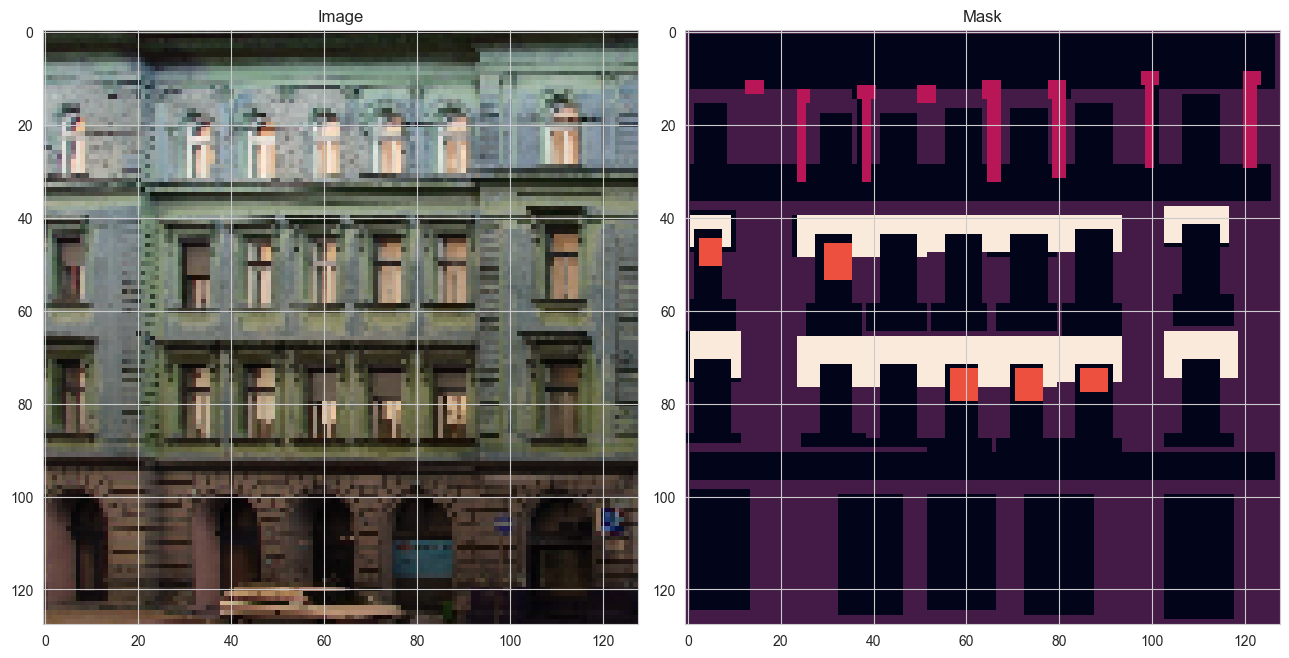

In [27]:
# выберем рандомно картинку и соответствующую ей маску
random_index = random.randint(0, len(X_train) - 1)
random_image = X_train[random_index]
random_mask = y_train[random_index]

# Display the image and its corresponding mask
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
ax[0].imshow(random_image)
ax[0].set_title('Image')
ax[1].imshow(random_mask.squeeze())
ax[1].set_title('Mask')
plt.tight_layout()
plt.show();

## Формируем простейшую архитектуру U-Net
Попробуем обучить две модели с разными слоями и на разном количестве эпох.

In [28]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - (dice_coefficient(y_true, y_pred))

In [29]:
# Зададим константы
NUM_EPOCHS = 20
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
VALIDATION_STEPS = len(X_valid) // BATCH_SIZE

INPUT_SHAPE = (128, 128, 3)

### Model 1

In [30]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [31]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input(INPUT_SHAPE)

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)

    model = keras.models.Model(inputs, outputs)

    return model

In [32]:
model = UNet()

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer, loss="binary_crossentropy", metrics=[dice_coefficient, 'accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [33]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [34]:
%%time

# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5',
                                      monitor='val_dice_coefficient',
                                      mode='max',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      verbose=1)

steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))

# Train the model and save the best model checkpoint
basic_UNet = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=2,
                    epochs=NUM_EPOCHS,
                    callbacks=[checkpoint_callback])

Epoch 1/20

Epoch 1: val_dice_coefficient improved from -inf to 0.01093, saving model to model_checkpoint.h5
10/10 - 104s - loss: 0.6954 - dice_coefficient: 0.0103 - accuracy: 0.2784 - val_loss: 0.6500 - val_dice_coefficient: 0.0109 - val_accuracy: 0.4763 - 104s/epoch - 10s/step
Epoch 2/20
10/10 - 97s - loss: 0.4492 - dice_coefficient: 0.0086 - accuracy: 0.5783 - 97s/epoch - 10s/step
Epoch 3/20
10/10 - 65s - loss: 0.1151 - dice_coefficient: 0.0032 - accuracy: 0.5524 - 65s/epoch - 7s/step
Epoch 4/20
10/10 - 67s - loss: 0.0778 - dice_coefficient: 0.0026 - accuracy: 0.6061 - 67s/epoch - 7s/step
Epoch 5/20
10/10 - 66s - loss: 0.0682 - dice_coefficient: 0.0051 - accuracy: 0.5835 - 66s/epoch - 7s/step
Epoch 6/20
10/10 - 65s - loss: 0.0553 - dice_coefficient: 0.0042 - accuracy: 0.5883 - 65s/epoch - 7s/step
Epoch 7/20
10/10 - 68s - loss: 0.0522 - dice_coefficient: 0.0053 - accuracy: 0.5313 - 68s/epoch - 7s/step
Epoch 8/20
10/10 - 70s - loss: 0.0445 - dice_coefficient: 0.0042 - accuracy: 0.5656

In [35]:
basic_UNet_accuracy = basic_UNet.history['accuracy']
print('Basic UNet accuracy:', basic_UNet_accuracy)

Basic UNet accuracy: [0.27838820219039917, 0.5782814025878906, 0.5523529052734375, 0.6061126589775085, 0.583453357219696, 0.5882608890533447, 0.5312550663948059, 0.565570056438446, 0.5138529539108276, 0.5284159183502197, 0.5774129033088684, 0.5763407349586487, 0.5701568722724915, 0.5685384273529053, 0.5611612796783447, 0.5518453121185303, 0.5828084349632263, 0.5645538568496704, 0.5688069462776184, 0.5246124267578125]


In [37]:
average_accuracy = sum(basic_UNet_accuracy) / len(basic_UNet_accuracy)
print('Average accuracy:', average_accuracy)

Average accuracy: 0.5486090302467346


In [36]:
last_best_accuracy = max(basic_UNet_accuracy)
print('Last best accuracy:', last_best_accuracy)

Last best accuracy: 0.6061126589775085


In [40]:
# Display Dice coefficient
last_best_dice = max(basic_UNet.history['dice_coefficient'])
print('Last best DICE:', last_best_dice)

Last best DICE: 0.010298362001776695


## Модель 2 (другой подход к предобработке), матрица не сошлась :(

In [395]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    return input_image, input_mask

In [396]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

In [397]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [411]:
def load_image_train(image_file, mask_file):
    try:
        input_image = tf.io.read_file(image_file)
        input_image = tf.image.decode_jpeg(input_image, channels=3)
        input_mask = tf.io.read_file(mask_file)
        input_mask = tf.image.decode_png(input_mask, channels=1)
        input_image, input_mask = resize(input_image, input_mask)
        input_image, input_mask = augment(input_image, input_mask)
        input_image, input_mask = normalize(input_image, input_mask)
        return input_image, input_mask
    except tf.errors.NotFoundError:
        print(f"File not found: {image_file} or {mask_file}")
        return None, None

def load_image_test(image_file, mask_file):
    try:
        input_image = tf.io.read_file(image_file)
        input_image = tf.image.decode_jpeg(input_image, channels=3)
        input_mask = tf.io.read_file(mask_file)
        input_mask = tf.image.decode_png(input_mask, channels=1)
        input_image, input_mask = resize(input_image, input_mask)
        input_image, input_mask = normalize(input_image, input_mask)
        return input_image, input_mask
    except tf.errors.NotFoundError:
        print(f"File not found: {image_file} or {mask_file}")
        return None, None

In [553]:
# Define data directories
origin_train = "C:\\Users\\HOME\\PycharmProjects\\train_origin"
origin_test = "C:\\Users\\HOME\\PycharmProjects\\test_origin"

# Read the training dataset
train_dataset = tf.data.Dataset.list_files(os.path.join(origin_train, "*.jpg"))
train_dataset = train_dataset.map(lambda x: (x, tf.strings.regex_replace(x, "jpg", "png")))
train_dataset = train_dataset.map(lambda x, y: load_image_train(x, y))
train_dataset = train_dataset.filter(lambda x, y: x is not None and y is not None)  # remove None values
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Read the test dataset and resize images
test_dataset = tf.data.Dataset.list_files(os.path.join(origin_test, "*.jpg"))
test_dataset = test_dataset.map(lambda x: (x, tf.strings.regex_replace(x, "jpg", "png")))
test_dataset = test_dataset.map(lambda x, y: load_image_test(x, y))
test_dataset = test_dataset.filter(lambda x, y: x is not None and y is not None)  # remove None values
test_dataset = test_dataset.shuffle(buffer_size=1000)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Create batches
train_batches = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(18).batch(BATCH_SIZE)
test_batches = test_dataset.skip(18).take(60).batch(BATCH_SIZE)

# Get the length of train_batches
try:
    num_train_batches = len(train_batches)
    print("Number of training batches:", num_train_batches)
except TypeError:
    print("The length of the training dataset is unknown.")

The length of the training dataset is unknown.


In [554]:
# type(train_dataset)

In [555]:
# print(train_dataset)

## U-Net Building blocks
Create the building blocks for making the components U-Net model.

In [43]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [44]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [45]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

## Build the U-Net Model

In [46]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [47]:
unet_model = build_unet_model()

In [48]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_19[0][0]']              
                                )                                                             

In [49]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

## Compile and Train U-Net

In [50]:
%%time
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

CPU times: total: 0 ns
Wall time: 6 ms


In [53]:
%%time
NUM_EPOCHS = 20

# STEPS_PER_EPOCH = int(np.ceil(len(train_dataset) / BATCH_SIZE))
# VALIDATION_STEPS = int(np.ceil(len(test_dataset) / BATCH_SIZE))

# unet_model_history = unet_model.fit(train_batches,
#                                epochs=NUM_EPOCHS,
#                                steps_per_epoch=STEPS_PER_EPOCH,
#                                validation_steps=VALIDATION_STEPS,
#                                validation_data=validation_batches)

# unet_model_history = unet_model.fit(X_train, y_train,
#                                epochs=NUM_EPOCHS,
#                                steps_per_epoch=STEPS_PER_EPOCH,
#                                validation_steps=VALIDATION_STEPS,
#                                validation_data=(X_valid, y_valid))

CPU times: total: 0 ns
Wall time: 0 ns


## Тестируем модель на тестовой выборке

#### Model 1

In [54]:
# from DataGen import DataGen
# import os
# import numpy as np
# from tensorflow.keras.models import load_model
# import tensorflow as tf

image_size = (128, 128)
batch_size = 16
CLASSES = 12

test = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\test"

test_path = os.path.abspath(test)
# print(os.listdir(test_path))

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - (dice_coefficient(y_true, y_pred))

# Load the saved model with the best weights
model = load_model("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\model_checkpoint.h5",
                   custom_objects={'dice_coefficient': dice_coefficient, 'dice_coef_loss': dice_coef_loss})

# Get list of image file paths in test path
test_ids = sorted([os.path.join(test, filename)
                    for filename in os.listdir(test)
                    if filename.endswith('.jpg') or filename.endswith('.png')])

test_gen = DataGen(test_ids, batch_size=batch_size, image_size=image_size)
test_steps = int(np.ceil(len(test_ids) / batch_size))

# Evaluate the model on the test set
test_loss, test_dice_coef, test_accuracy= model.evaluate(test_gen, steps=test_steps)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Dice Coefficient:", test_dice_coef)

"""
Test Loss: 0.6521443128585815
Test Accuracy: 0.46856847405433655
Test Dice Coefficient: 0.010825795121490955
"""

10/10 [==============================] - 24s 2s/step - loss: 0.6521 - dice_coefficient: 0.0108 - accuracy: 0.4686
Test Loss: 0.6521443128585815
Test Accuracy: 0.46856847405433655
Test Dice Coefficient: 0.010825795121490955
